In [130]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve,accuracy_score,classification_report,f1_score

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandasql import sqldf

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.dummy import DummyClassifier
import scipy.stats as st

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 5)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [88]:
df = pd.read_csv('data.csv')

In [89]:
x = df[['country', 'year', 'uniqueid', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type']]


y = df[['bank_account']]

x_tr, x_test, y_tr, y_test = train_test_split(x, y,test_size=.25, random_state=12)

In [90]:
x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
x_tr['is_male'] = np.where(x_tr['gender_of_respondent'] == 'Male',1,0)
x_tr['is_youth'] = np.where(x_tr['age_of_respondent'] <= 35,1,0)
x_tr['hh_5'] = np.where(x_tr['household_size'] <= 5,1,0)

<ipython-input-90-88c8f1b9bbf0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
<ipython-input-90-88c8f1b9bbf0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
<ipython-input-90-88c8f1b9bbf0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [91]:
x_tr_cont = x_tr[['year','hh_5','is_youth','is_urban','cellphone','is_male']]
x_tr_cat = x_tr[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [92]:
# Regroup to reduce number of categories
x_tr_cat.loc[x_tr_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_tr_cat.loc[x_tr_cat['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_tr_cat.loc[x_tr_cat['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_tr_cat.loc[x_tr_cat['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-92-fd79ac22a8b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr_cat.loc[x_tr_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-92-fd79ac22a8b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [93]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_tr_cat)

ohe_x_train = ohe.transform(x_tr_cat)

columns = ohe.get_feature_names(['country',
                                 'relationship_with_head', 
                                 'marital_status',
                                 'education_level', 
                                 'job_type'])

ohe_x_tr_df = pd.DataFrame(ohe_x_train, columns=columns, index=x_tr.index)

In [94]:
combo_train_df = pd.concat([x_tr_cont, ohe_x_tr_df], axis=1)

In [95]:
# Create dummy variable for bank account
y_tr['no_acc'] = np.where(y_tr['bank_account'] == 'No', 1,0)

<ipython-input-95-d1325f426412>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_tr['no_acc'] = np.where(y_tr['bank_account'] == 'No', 1,0)


In [96]:
x_train, x_val, y_train, y_val = train_test_split(combo_train_df, y_tr, test_size=.20, random_state=11)

In [97]:
y_train.drop(columns='bank_account',inplace=True)
y_val.drop(columns='bank_account',inplace=True)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


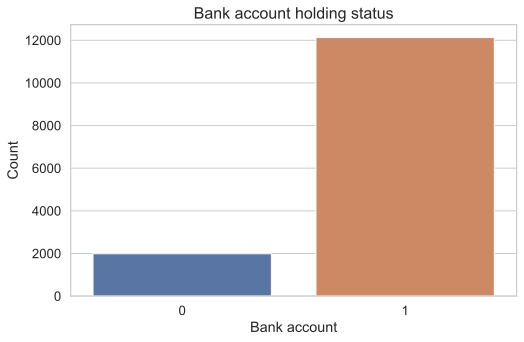

In [98]:
sns.countplot(x='no_acc', data=y_train)
plt.title('Bank account holding status',family='arial',fontsize=16)
plt.xlabel('Bank account')
plt.ylabel('Count')
plt.show;

In [99]:
count_no_acc = len(y_train[y_train['no_acc']==1])
count_acc = len(y_train[y_train['no_acc']==0])
pct_of_no_acc = count_no_acc/(count_no_acc+count_acc)
print("percentage of no account:", pct_of_no_acc*100)
pct_of_acc = count_acc/(count_no_acc+count_acc)
print("percentage of account", pct_of_acc*100)

percentage of no account: 85.9288649567805
percentage of account 14.071135043219499


Classes are __very imbalanced__ - investigate threshold, over and undersampling

In [100]:
df_train = pd.concat([x_train,y_train],axis=1)
df_val = pd.concat([x_val,y_val],axis=1)

## Naive Bayes

All features, no interactions

In [103]:
features = ['year', 'hh_5', 'is_youth', 'is_urban', 'cellphone', 'is_male',
       'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

In [104]:
nb = BernoulliNB()
nb.fit(df_train[features],df_train['no_acc'])
print('Accuracy of Naive Bayes classifier on val set: {:.3f}'.format(
    nb.score(df_val[features],df_val['no_acc'])))

Accuracy of Naive Bayes classifier on val set: 0.874


In [105]:
y_pred = nb.predict(df_val[features])
print(confusion_matrix(df_val['no_acc'],y_pred))

[[ 204  288]
 [ 156 2881]]


In [106]:
print(classification_report(df_val['no_acc'],y_pred))

              precision    recall  f1-score   support

           0       0.57      0.41      0.48       492
           1       0.91      0.95      0.93      3037

    accuracy                           0.87      3529
   macro avg       0.74      0.68      0.70      3529
weighted avg       0.86      0.87      0.87      3529



In [107]:
df_val['proba_bank'] = nb.predict_proba(df_val[features])[:, 1]

fpr1, tpr1, thresholds1 = roc_curve(df_val['no_acc'],
                                 df_val['proba_bank'])

In [108]:
def plot_roc(true, probas,fpr,tpr):
    auc = roc_auc_score(true, probas)
    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");

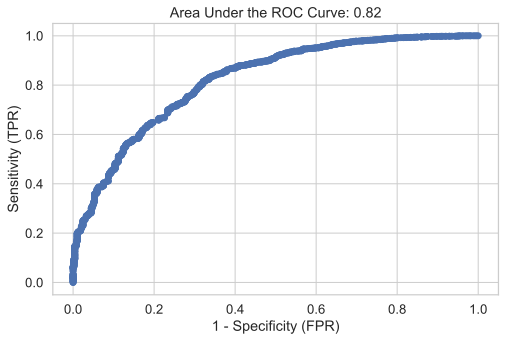

In [109]:
plot_roc(df_val['no_acc'], df_val['proba_bank'],fpr1,tpr1)

Pretty good. However, while F1 score is better for Naive Bayes than logistic regression, there is slightly higher ROC AUC for logistic regression

## Compare to logistic regression model 13 

In [112]:
df_train_2 = df_train.drop(['year','hh_5','relationship_with_head_Other relative','relationship_with_head_Parent'],
                          axis=1)
df_val_2 = df_val.drop(['year','hh_5','relationship_with_head_Other relative','relationship_with_head_Parent'],
                          axis=1)

features2 = ['is_youth','is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse', 
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

In [113]:
nb2 = BernoulliNB()
nb2.fit(df_train_2[features2],df_train_2['no_acc'])
print('Accuracy of Naive Bayes classifier on val set: {:.3f}'.format(
    nb2.score(df_val_2[features2],df_val_2['no_acc'])))

Accuracy of Naive Bayes classifier on val set: 0.876


In [114]:
y_pred2 = nb2.predict(df_val_2[features2])
print(confusion_matrix(df_val_2['no_acc'],y_pred2))

[[ 203  289]
 [ 148 2889]]


In [118]:
print(classification_report(df_val_2['no_acc'],y_pred2))

              precision    recall  f1-score   support

           0       0.58      0.41      0.48       492
           1       0.91      0.95      0.93      3037

    accuracy                           0.88      3529
   macro avg       0.74      0.68      0.71      3529
weighted avg       0.86      0.88      0.87      3529



In [119]:
df_val_2['proba_bank'] = nb2.predict_proba(df_val_2[features2])[:, 1]

fpr2, tpr2, thresholds2 = roc_curve(df_val_2['no_acc'],
                                 df_val_2['proba_bank'])

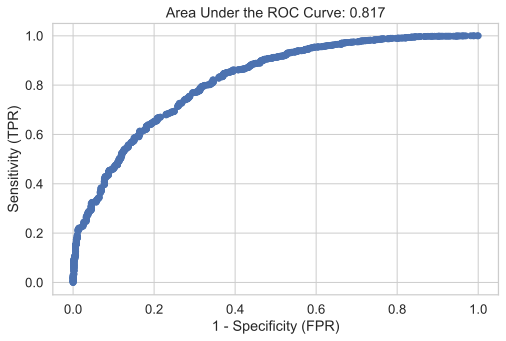

In [120]:
plot_roc(df_val_2['no_acc'], df_val_2['proba_bank'],fpr2,tpr2)

## Testing the model on the test set

Note the first analysis is based on the first multiple regression model above (including all features, no interactions)

1. Preparing the test sample 

In [121]:
x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
x_test['is_male'] = np.where(x_test['gender_of_respondent'] == 'Male',1,0)
x_test['is_youth'] = np.where(x_test['age_of_respondent'] <= 35,1,0)
x_test['hh_5'] = np.where(x_test['household_size'] <= 5,1,0)

<ipython-input-121-b57eb4bc7d75>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
<ipython-input-121-b57eb4bc7d75>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
<ipython-input-121-b57eb4bc7d75>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [122]:
x_test_cont = x_test[['year','hh_5','is_youth','is_urban','cellphone','is_male']]
x_test_cat = x_test[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [123]:
x_test_cat.loc[x_test_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_test_cat.loc[x_test_cat['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_test_cat.loc[x_test_cat['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_test_cat.loc[x_test_cat['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-123-c58a8d9a8085>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_cat.loc[x_test_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-123-c58a8d9a8085>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [124]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_test_cat)

ohe_x_test = ohe.transform(x_test_cat)

columns = ohe.get_feature_names(['country','relationship_with_head', 'marital_status',
       'education_level', 'job_type'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=x_test.index)

In [125]:
combo_test_df = pd.concat([x_test_cont, ohe_x_test_df], axis=1)

In [126]:
y_test['no_acc'] = np.where(y_test['bank_account'] == 'No', 1,0)

df_test = pd.concat([combo_test_df,y_test],axis=1)

<ipython-input-126-2b95f0bf7c13>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['no_acc'] = np.where(y_test['bank_account'] == 'No', 1,0)


## Testing on nb model 2

In [127]:
print('Accuracy of Naive Bayes classifier on test set: {:.3f}'.format(
    nb2.score(df_test[features2],df_test['no_acc'])))

Accuracy of Naive Bayes classifier on test set: 0.873


In [128]:
y_pred2t = nb2.predict(df_test[features2])
print(confusion_matrix(df_test['no_acc'],y_pred2t))

[[ 349  485]
 [ 262 4785]]


In [129]:
print(classification_report(df_test['no_acc'],y_pred2t))

              precision    recall  f1-score   support

           0       0.57      0.42      0.48       834
           1       0.91      0.95      0.93      5047

    accuracy                           0.87      5881
   macro avg       0.74      0.68      0.71      5881
weighted avg       0.86      0.87      0.86      5881



In [132]:
f1_2t = f1_score(df_test['no_acc'], y_pred2t)
print('F1 score for unbanked in model 2:')
f1_2t

F1 score for unbanked in model 2:


0.9275952311718522

Consistent performance on val and test - not over or underfitting